Sandy Cove Analysis  Aug 19, 2017

In [2]:
import arrow
from datetime import datetime, timedelta
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr

from salishsea_tools import data_tools, places
import shared

%matplotlib inline

# Statistics Functions

In [3]:
def rmse(predictions, targets):
    return np.sqrt(np.nanmean((predictions - targets) ** 2))
def bias(predictions, targets):
    return np.nanmean(predictions - targets)
def willmott(predictions, targets):
    xbar = np.nanmean(targets)
    return (1 - (np.nansum((predictions - targets)**2))  / 
                             np.nansum((np.abs(predictions - xbar)
                                     + np.abs(targets - xbar))**2))

# Set-up Location and Dates

In [4]:
filename = 'SandyCove'
place = 'Sandy Cove'
mean_sea_lvl = places.PLACES[place]['mean sea lvl']

In [5]:
start = datetime(2017, 8, 21)
end = datetime(2018, 5, 8)

# Get Model Results

In [6]:
ssh = xr.open_dataset('/results/SalishSea/nowcast-green/20aug17/'+filename+'.nc')
for aday in arrow.Arrow.range('day', start, end):
    day = aday.format('DDMMMYY').lower()
    newdata = xr.open_dataset('/results/SalishSea/nowcast-green/'+day+'/'+filename+'.nc')
    ssh = xr.concat([ssh, newdata], dim='time_counter')

In [7]:
# Save just in case
ssh.to_netcdf('sandycove.nc')

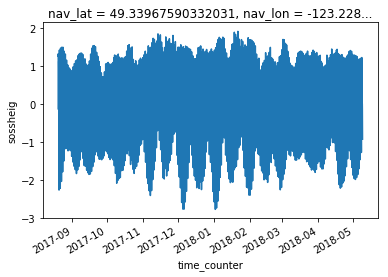

In [9]:
ssh.sossheig.plot();

# Get Observations

In [10]:
obs_1min = data_tools.get_chs_tides(
            'obs',
            place,
            arrow.get(str(ssh.time_counter[0].values)) -
            timedelta(seconds=5 * 60),
            arrow.get(str(ssh.time_counter[-1].values))
        )
obs_10min_avg = xr.DataArray(
            obs_1min.resample('10min', loffset='5min').mean()
        )
obs = xr.Dataset({
            'water_level': obs_10min_avg.rename({
                'dim_0': 'time'
            })
        })

KeyboardInterrupt: 

In [ ]:
# Save just in case
obs.to_netcdf('SCobc.nc')

In [11]:
# Read it in for speed
obs = xr.open_dataset('SCobc.nc')

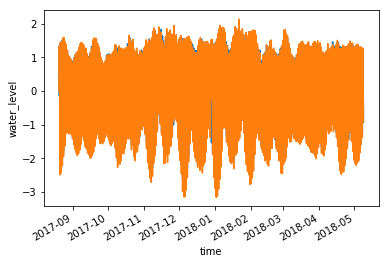

In [15]:
ssh.sossheig.plot()
(obs.water_level - mean_sea_lvl).plot();

# Base Comparison

In [46]:
#plt.plot(obs.water_level, ssh.sossheig.data[:, 0, 0], 'o')
print('RMSE', rmse(ssh.sossheig.data[:, 0, 0], obs.water_level - mean_sea_lvl))
print('bias', bias(ssh.sossheig.data[:, 0, 0], obs.water_level - mean_sea_lvl))
print('Willmott', willmott(ssh.sossheig.data[:, 0, 0], obs.water_level - mean_sea_lvl))

RMSE 0.105347847994
bias 0.0307859186572
Willmott 0.996905645365


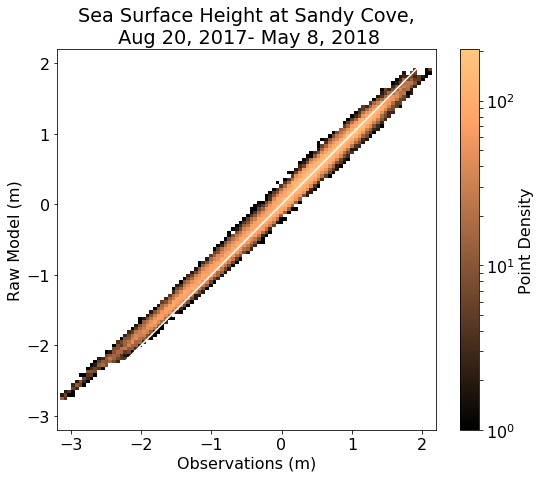

In [47]:
ssh_obs = np.array(obs.water_level) - mean_sea_lvl
ssh_model = np.array(ssh.sossheig.data[:, 0, 0])
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize = (8.5, 7))
c, xedge, yedge, im = ax.hist2d(ssh_obs[~np.isnan(ssh_obs)],
                                ssh_model[~np.isnan(ssh_obs)], bins = 100, norm=LogNorm(), cmap='copper')
im
ax.plot([-3.2, 2.2], [-3.2, 2.2], 'w')
ax.set_xlim((-3.2, 2.2))
ax.set_ylim((-3.2, 2.2))
ax.set_xlabel('Observations (m)')
ax.set_ylabel('Raw Model (m)')
ax.set_title('Sea Surface Height at Sandy Cove,\n Aug 20, 2017- May 8, 2018')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Point Density')

# Get tidal Predictions

In [21]:
tidal_predictions = '/results/nowcast-sys/SalishSeaNowcast/tidal_predictions/'
model_ssh_period = slice(
        str(ssh.time_centered[0].values), 
        str(ssh.time_centered[-1].values))

# Predicted tide water levels dataset from ttide
ttide = shared.get_tides(place, tidal_predictions)
ttide.rename(columns={' pred_noshallow ': 'pred_noshallow'}, inplace=True)
ttide.index = ttide.time
ttide_full = xr.Dataset.from_dataframe(ttide)
ttide_ds = ttide_full.sel(time=model_ssh_period)

In [ ]:
# Save just in case
ttide_ds.to_netcdf('extract_pred.nc')

(0, 200)

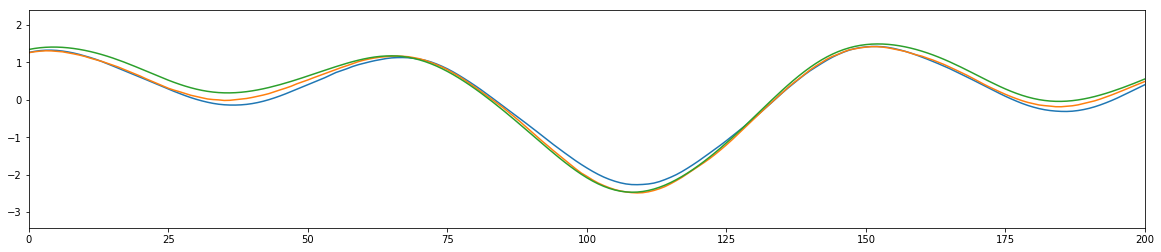

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
ax.plot(ssh.sossheig[:, 0, 0])
ax.plot(obs.water_level - mean_sea_lvl)
ax.plot(ttide_ds.pred_all)
ax.set_xlim((0, 200))

# Correct the Model

In [23]:
ssh_correction = ttide_ds.pred_noshallow - ttide_ds.pred_8
ssh_corrected = np.array(ssh.sossheig[:, 0, 0].values) + np.array(ssh_correction.values)

In [45]:
#plt.plot(obs.water_level, ssh_corrected, 'o')
print('RMSE', rmse(ssh_corrected, obs.water_level - mean_sea_lvl))
print('bias', bias(ssh_corrected, obs.water_level - mean_sea_lvl))
print('Willmott', willmott(ssh_corrected, obs.water_level - mean_sea_lvl))

RMSE 0.0834871724631
bias 0.0309168653373
Willmott 0.998085656952


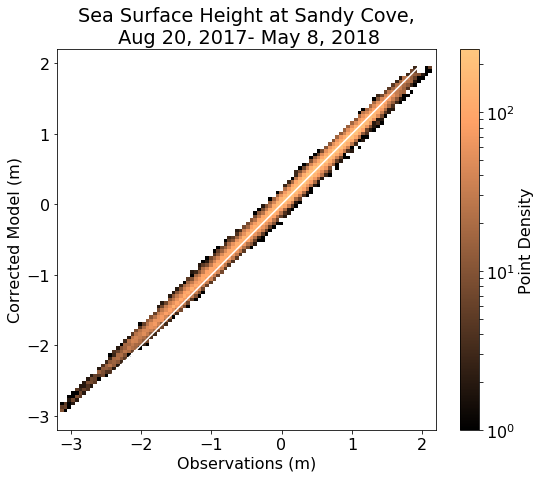

In [44]:
ssh_obs = np.array(obs.water_level) - mean_sea_lvl
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize = (8.5, 7))
c, xedge, yedge, im = ax.hist2d(ssh_obs[~np.isnan(ssh_obs)],
                                ssh_corrected[~np.isnan(ssh_obs)], bins = 100, norm=LogNorm(), cmap='copper')
im
ax.plot([-3.2, 2.2], [-3.2, 2.2], 'w')
ax.set_xlim((-3.2, 2.2))
ax.set_ylim((-3.2, 2.2))
ax.set_xlabel('Observations (m)')
ax.set_ylabel('Corrected Model (m)')
ax.set_title('Sea Surface Height at Sandy Cove,\n Aug 20, 2017- May 8, 2018')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Point Density')

# Look at Residuals

In [25]:
residual_model = ssh_corrected - np.array(ttide_ds.pred_all.values)
residual_obs = np.array(obs.water_level) - mean_sea_lvl - np.array(ttide_ds.pred_all.values)

In [26]:
print('RMSE', rmse(residual_model, residual_obs))
print('bias', bias(residual_model, residual_obs))
print('Willmott', willmott(residual_model, residual_obs))

RMSE 0.0834871724631
bias 0.0309168653373
Willmott 0.947058353941


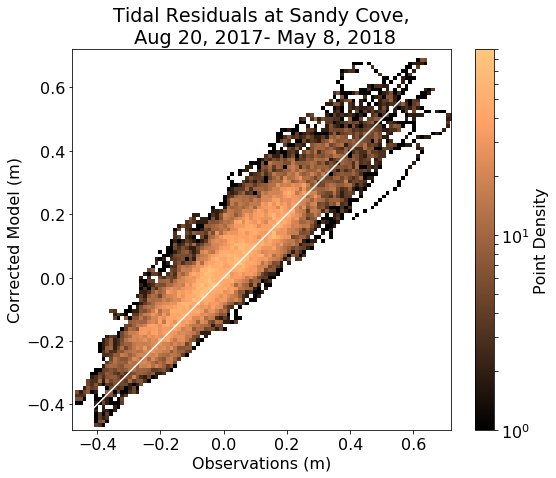

In [27]:
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize = (8.5, 7))
c, xedge, yedge, im = ax.hist2d(residual_obs[~np.isnan(residual_obs)], 
                                residual_model[~np.isnan(residual_obs)], bins = 100, norm=LogNorm(), cmap='copper')
im
ax.plot([-0.48, 0.72], [-0.48, 0.72], 'w')
ax.set_xlim((-0.48, 0.72))
ax.set_ylim((-0.48, 0.72))
ax.set_xlabel('Observations (m)')
ax.set_ylabel('Corrected Model (m)')
ax.set_title('Tidal Residuals at Sandy Cove,\n Aug 20, 2017- May 8, 2018')
cb = fig.colorbar(im, ax=ax)
cb.set_label('Point Density')